#  <font color='red'>HJCFIT- maximum likelihood fit of single-channel data: </font> 
###  <font color='red'>Records at four concentrations fitted simultaneously</font> 

Some general settings:

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys, time, math
import numpy as np
from numpy import linalg as nplin

### Load data

HJCFIT depends on DCPROGS/DCPYPS module for data input and setting kinetic mechanism:

In [3]:
from dcpyps.samples import samples
from dcpyps import dataset, mechanism, dcplots, dcio

In [4]:
# LOAD DATA: Burzomato 2004 example set.
scnfiles = [["./samples/glydemo/A-10.scn"], 
            ["./samples/glydemo/B-30.scn"],
            ["./samples/glydemo/C-100.scn"], 
            ["./samples/glydemo/D-1000.scn"]]
tr = [0.000030, 0.000030, 0.000030, 0.000030]
tc = [0.004, -1, -0.06, -0.02]
conc = [10e-6, 30e-6, 100e-6, 1000e-6]

Initialise Single-Channel Record from dcpyps. Note that SCRecord takes a list of file names; several SCN files from the same patch can be loaded.

In [5]:
# Initaialise SCRecord instance.
recs = []
bursts = []
for i in range(len(scnfiles)):
    rec = dataset.SCRecord(scnfiles[i], conc[i], tr[i], tc[i])
    recs.append(rec)
    bursts.append(rec.bursts.intervals())
    rec.printout()



 Data loaded from file: ./samples/glydemo/A-10.scn
Concentration of agonist = 10.000 microMolar
Resolution for HJC calculations = 30.0 microseconds
Critical gap length to define end of group (tcrit) = 4.000 milliseconds
	(defined so that all openings in a group prob come from same channel)
Initial and final vectors for bursts calculated asin Colquhoun, Hawkes & Srodzinski, (1996, eqs 5.8, 5.11).

Number of resolved intervals = 14553
Number of resolved periods = 12322

Number of open periods = 6161
Mean and SD of open periods = 1.288416455 +/- 1.982357659 ms
Range of open periods from 0.030309819 ms to 29.300385504 ms

Number of shut intervals = 6161
Mean and SD of shut periods = 69.358758628 +/- 259.539574385 ms
Range of shut periods from 0.030003177 ms to 6902.281761169 ms
Last shut period = 115.868724883 ms

Number of bursts = 1480
Average length = 6.106142638 ms
Range: 0.039 to 261.102 millisec
Average number of openings= 4.162837838


 Data loaded from file: ./samples/glydemo/B-3

### Load demo mechanism (C&H82 numerical example)

In [6]:
# LOAD FLIP MECHANISM USED in Burzomato et al 2004
mecfn = "./samples/mec/demomec.mec"
version, meclist, max_mecnum = dcio.mec_get_list(mecfn)
mec = dcio.mec_load(mecfn, meclist[2][0])

In [7]:
# PREPARE RATE CONSTANTS.
# Fixed rates.
#fixed = np.array([False, False, False, False, False, False, False, True,
#    False, False, False, False, False, False])
for i in range(len(mec.Rates)):
    mec.Rates[i].fixed = False

# Constrained rates.
mec.Rates[21].is_constrained = True
mec.Rates[21].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[21].constrain_args = [17, 3]
mec.Rates[19].is_constrained = True
mec.Rates[19].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[19].constrain_args = [17, 2]
mec.Rates[16].is_constrained = True
mec.Rates[16].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[16].constrain_args = [20, 3]
mec.Rates[18].is_constrained = True
mec.Rates[18].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[18].constrain_args = [20, 2]
mec.Rates[8].is_constrained = True
mec.Rates[8].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[8].constrain_args = [12, 1.5]
mec.Rates[13].is_constrained = True
mec.Rates[13].constrain_func = mechanism.constrain_rate_multiple
mec.Rates[13].constrain_args = [9, 2]
mec.update_constrains()
# Rates constrained by microscopic reversibility
mec.set_mr(True, 7, 0)
mec.set_mr(True, 14, 1)

# Update constrains
mec.update_constrains()

In [8]:
#Propose initial guesses different from recorded ones 
initial_guesses = [5000.0, 500.0, 2700.0, 2000.0, 800.0, 15000.0, 300.0, 120000, 6000.0,
                   0.45E+09, 1500.0, 12000.0, 4000.0, 0.9E+09, 7500.0, 1200.0, 3000.0, 
                   0.45E+07, 2000.0, 0.9E+07, 1000, 0.135E+08]

#initial_guesses = [3687.69, 6091.43, 2467.35, 32621.5, 7061.15, 129984., 1050.69, 20984., 3387.64,
#                   0.166224E+09, 20783.8, 6308.02, 2258.42, 0.332447E+09, 31335.4, 144.530, 831.686, 
#                   0.620171E+06, 554.457, 0.124034E+07, 277.229, 0.186051E+07]

#initial_guesses = mec.unit_rates()
mec.set_rateconstants(initial_guesses)
mec.update_constrains()
mec.printout()


class dcpyps.Mechanism
Values of unit rates [1/sec]:
0	From AF*  	to AF    	alpha1       	5000.0
1	From AF  	to AF*    	beta1        	500.0
2	From A2F*  	to A2F    	alpha2       	2700.0
3	From A2F  	to A2F*    	beta2        	2000.0
4	From A3F*  	to A3F    	alpha3       	800.0
5	From A3F  	to A3F*    	beta3        	15000.0
6	From A3F  	to A3R    	gama3        	300.0
7	From A3R  	to A3F    	delta3       	120000.0
8	From A3F  	to A2F    	3kf(-3)      	6000.0
9	From A2F  	to A3F    	kf(+3)       	450000000.0
10	From A2F  	to A2R    	gama2        	1500.0
11	From A2R  	to A2F    	delta2       	12000.0
12	From A2F  	to AF    	2kf(-2)      	4000.0
13	From AF  	to A2F    	2kf(+2)      	900000000.0
14	From AF  	to AR    	gama1        	7500.0
15	From AR  	to AF    	delta1       	1200.0
16	From A3R  	to A2R    	3k(-3)       	3000
17	From A2R  	to A3R    	k(+3)        	4500000.0
18	From A2R  	to AR    	2k(-2)       	2000
19	From AR  	to A2R    	2k(+2)       	9000000.0
20	From AR  	to R    	k(-1)  

### Check data histograms and probability densities calculated from initial guesses

Plot dwell-time histograms for inspection. In single-channel analysis field it is common to plot these histograms with x-axis in log scale and y-axis in square-root scale. After such transformation exponential pdf has a bell-shaped form.

Note that to properly overlay ideal and missed-event corrected pdfs ideal pdf has to be scaled (need to renormailse to 1 the area under pdf from $\tau_{res}$). 

In [9]:
# Scale for ideal pdf
def scalefac(tres, matrix, phiA):
    eigs, M = eig(-matrix)
    N = inv(M)
    k = N.shape[0]
    A, w = np.zeros((k, k, k)), np.zeros(k)
    for i in range(k):
        A[i] = np.dot(M[:, i].reshape(k, 1), N[i].reshape(1, k))
    for i in range(k):
        w[i] = np.dot(np.dot(np.dot(phiA, A[i]), (-matrix)), np.ones((k, 1)))
    return 1 / np.sum((w / eigs) * np.exp(-tres * eigs))

In [10]:
from dcprogs.likelihood import QMatrix
from dcprogs.likelihood import missed_events_pdf, ideal_pdf, IdealG, eig, inv

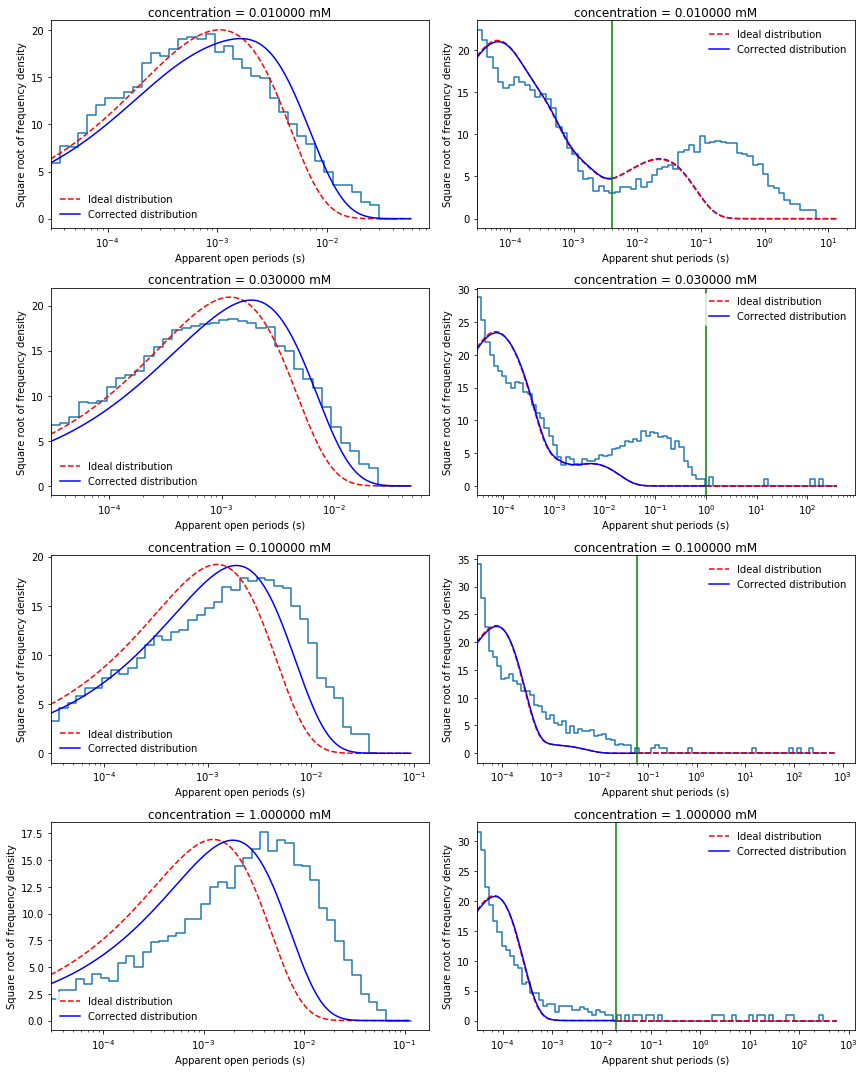

In [11]:
fig, axes = plt.subplots(len(recs), 2, figsize=(12,15))
for i in range(len(recs)):
    mec.set_eff('c', recs[i].conc)
    qmatrix = QMatrix(mec.Q, mec.kA)
    idealG = IdealG(qmatrix)
    
    # Plot apparent open period histogram
    ipdf = ideal_pdf(qmatrix, shut=False) 
    iscale = scalefac(recs[i].tres, qmatrix.aa, idealG.initial_occupancies)
    epdf = missed_events_pdf(qmatrix, recs[i].tres, nmax=2, shut=False)
    dcplots.xlog_hist_HJC_fit(axes[i,0], recs[i].tres, recs[i].opint,
                               epdf, ipdf, iscale, shut=False)
    axes[i,0].set_title('concentration = {0:3f} mM'.format(recs[i].conc*1000))

    # Plot apparent shut period histogram
    ipdf = ideal_pdf(qmatrix, shut=True)
    iscale = scalefac(recs[i].tres, qmatrix.ff, idealG.final_occupancies)
    epdf = missed_events_pdf(qmatrix, recs[i].tres, nmax=2, shut=True)
    dcplots.xlog_hist_HJC_fit(axes[i,1], recs[i].tres, recs[i].shint,
                               epdf, ipdf, iscale, tcrit=math.fabs(recs[i].tcrit))
    axes[i,1].set_title('concentration = {0:6f} mM'.format(recs[i].conc*1000))

fig.tight_layout()

### Prepare likelihood function

In [12]:
def dcprogslik(x, lik, m, c):
    m.theta_unsqueeze(np.exp(x))
    l = 0
    for i in range(len(c)):
        m.set_eff('c', c[i])
        l += lik[i](m.Q)
    return -l * math.log(10)

In [13]:
def printiter(theta):
    global iternum, likelihood, mec, conc
    iternum += 1
    if iternum % 100 == 0:
        lik = dcprogslik(theta, likelihood, mec, conc)
        print("iteration # {0:d}; log-lik = {1:.6f}".format(iternum, -lik))
        print(np.exp(theta))

In [14]:
# Import HJCFIT likelihood function
from dcprogs.likelihood import Log10Likelihood

kwargs = {'nmax': 2, 'xtol': 1e-12, 'rtol': 1e-12, 'itermax': 100,
    'lower_bound': -1e6, 'upper_bound': 0}
likelihood = []

for i in range(len(recs)):
    likelihood.append(Log10Likelihood(bursts[i], mec.kA,
        recs[i].tres, recs[i].tcrit, **kwargs))

In [15]:
# Extract free parameters
theta = mec.theta()
print ('\ntheta=', theta)
print('Number of free parameters = ', len(theta))


theta= [  5.00000000e+03   5.00000000e+02   2.70000000e+03   2.00000000e+03
   8.00000000e+02   1.50000000e+04   3.00000000e+02   4.50000000e+08
   1.50000000e+03   1.20000000e+04   4.00000000e+03   1.20000000e+03
   4.50000000e+06   1.00000000e+03]
Number of free parameters =  14


In [16]:
lik = dcprogslik(np.log(theta), likelihood, mec, conc)
print ("\nInitial likelihood = {0:.6f}".format(-lik))


Initial likelihood = 237961.490136


### Run optimisation

To keep execution time of this notebook short we only run the optimization for 200 iterations. Change `maxiter` below for a more realistic optimisation.

In [17]:
from scipy.optimize import minimize
print ("\nScyPy.minimize (Nelder-Mead) Fitting started: " +
       "%4d/%02d/%02d %02d:%02d:%02d"%time.localtime()[0:6])
iternum = 0
start = time.clock()
start_wall = time.time()
maxiter = 200
# maxiter = 30000
result = minimize(dcprogslik, np.log(theta), args=(likelihood, mec, conc), method='Nelder-Mead', callback=printiter, 
                  options={'xtol':1e-5, 'ftol':1e-5, 'maxiter': maxiter, 'maxfev': 150000, 'disp': True})
t3 = time.clock() - start
t3_wall = time.time() - start_wall
print ("\nScyPy.minimize (Nelder-Mead) Fitting finished: " +
       "%4d/%02d/%02d %02d:%02d:%02d"%time.localtime()[0:6])
print ('\nCPU time in ScyPy.minimize (Nelder-Mead)=', t3)
print ('Wall clock time in ScyPy.minimize (Nelder-Mead)=', t3_wall)
print ('\nResult   ==========================================\n', result)


ScyPy.minimize (Nelder-Mead) Fitting started: 2016/09/05 10:51:33
iteration # 100; log-lik = 263117.756238
[  5.29171999e+03   3.67684624e+02   1.41434237e+03   8.42349605e+03
   8.62838471e+02   5.14562348e+04   3.05197111e+02   5.19871117e+07
   2.31972504e+03   2.00532661e+04   4.15472395e+03   5.07080801e+02
   5.01742534e+05   8.94263677e+02]

ScyPy.minimize (Nelder-Mead) Fitting finished: 2016/09/05 10:51:38

CPU time in ScyPy.minimize (Nelder-Mead)= 12.988304999999999
Wall clock time in ScyPy.minimize (Nelder-Mead)= 4.555490016937256

Result   ==========================================
  final_simplex: (array([[  8.17854356,   6.03708337,   7.10706279,   9.07985218,
          6.93061081,  10.98001309,   5.8136173 ,  17.23832524,
          7.72769902,   9.70103791,   8.19758666,   6.45112468,
         13.39684638,   6.95508465],
       [  8.22403089,   6.05593405,   7.12875747,   9.02313412,
          6.90356027,  10.95712368,   5.77448477,  17.24438837,
          7.73601058,   

In [18]:
print ("\nFinal likelihood = {0:.16f}".format(-result.fun))
mec.theta_unsqueeze(np.exp(result.x))
print ("\nFinal rate constants:")
mec.printout()


Final likelihood = 263352.6097711687325500

Final rate constants:

class dcpyps.Mechanism
Values of unit rates [1/sec]:
0	From AF*  	to AF    	alpha1       	3563.66062627
1	From AF  	to AF*    	beta1        	418.670145871
2	From A2F*  	to A2F    	alpha2       	1220.55723999
3	From A2F  	to A2F*    	beta2        	8776.66858648
4	From A3F*  	to A3F    	alpha3       	1023.11872432
5	From A3F  	to A3F*    	beta3        	58689.3222512
6	From A3F  	to A3R    	gama3        	334.828110598
7	From A3R  	to A3F    	delta3       	64801.2535522
8	From A3F  	to A2F    	3kf(-3)      	5448.26105245
9	From A2F  	to A3F    	kf(+3)       	30655579.3113
10	From A2F  	to A2R    	gama2        	2270.3721034
11	From A2R  	to A2F    	delta2       	16334.5522045
12	From A2F  	to AF    	2kf(-2)      	3632.17403497
13	From AF  	to A2F    	2kf(+2)      	61311158.6227
14	From AF  	to AR    	gama1        	2368.25771823
15	From AR  	to AF    	delta1       	633.414278499
16	From A3R  	to A2R    	3k(-3)       	3145.40

### Plot experimental histograms and predicted pdfs

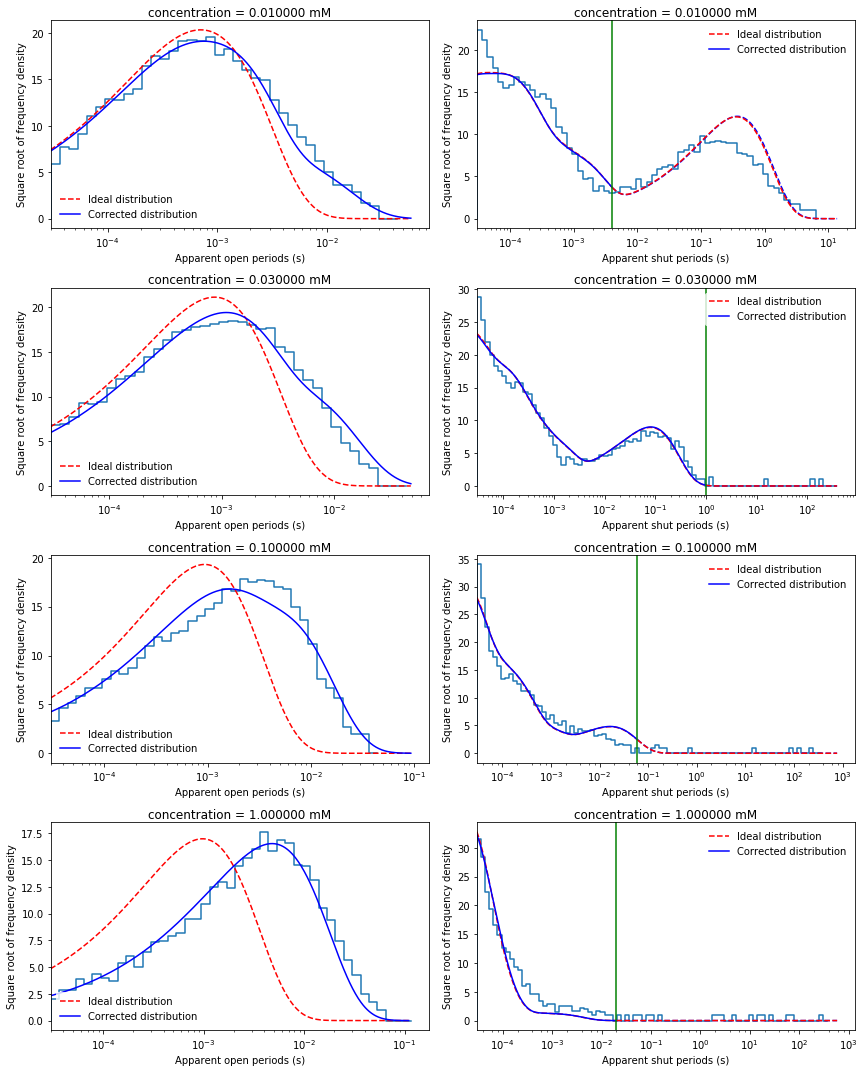

In [19]:
fig, axes = plt.subplots(len(recs), 2, figsize=(12,15))
for i in range(len(recs)):
    mec.set_eff('c', recs[i].conc)
    qmatrix = QMatrix(mec.Q, mec.kA)
    idealG = IdealG(qmatrix)
    
    # Plot apparent open period histogram
    ipdf = ideal_pdf(qmatrix, shut=False) 
    iscale = scalefac(recs[i].tres, qmatrix.aa, idealG.initial_occupancies)
    epdf = missed_events_pdf(qmatrix, recs[i].tres, nmax=2, shut=False)
    dcplots.xlog_hist_HJC_fit(axes[i,0], recs[i].tres, recs[i].opint,
                               epdf, ipdf, iscale, shut=False)
    axes[i,0].set_title('concentration = {0:3f} mM'.format(conc[i]*1000))

    # Plot apparent shut period histogram
    ipdf = ideal_pdf(qmatrix, shut=True)
    iscale = scalefac(recs[i].tres, qmatrix.ff, idealG.final_occupancies)
    epdf = missed_events_pdf(qmatrix, recs[i].tres, nmax=2, shut=True)
    dcplots.xlog_hist_HJC_fit(axes[i,1], recs[i].tres, recs[i].shint,
                               epdf, ipdf, iscale, tcrit=math.fabs(recs[i].tcrit))
    axes[i,1].set_title('concentration = {0:6f} mM'.format(conc[i]*1000))

fig.tight_layout()

Note that in this record only shut time intervals shorter than critical time ($t_{crit}$) were used to minimise likelihood. Thus, only a part of shut time histrogram (to the left from green line, indicating $t_{crit}$ value, in the above plot) is predicted well by rate constant estimates.